In [39]:
import pandas as pd
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import cv2
import os
from tqdm import tqdm

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"


# Обработка исходных датасетов

In [40]:
with open('labels_json/train_labels.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
    
train_df = pd.DataFrame.from_dict(train_data, orient='index').reset_index()
train_df.rename(columns={"index": "video_id"}, inplace=True)

In [41]:
with open('labels_json/test_labels.json', 'r', encoding='utf-8') as f:
    test_data = json.load(f)

test_df = pd.DataFrame.from_dict(test_data, orient='index').reset_index()
test_df.rename(columns={"index": "video_id"}, inplace=True)

In [42]:
train_df.head()


,video_id,url,name,start,end
0,-220020068_456255414,https://vkvideo.ru/video-220020068_456255414,"Баскетс. 4 сезон, 7 серия",0:01:42,0:01:47
1,-220020068_456249693,https://vkvideo.ru/video-220020068_456249693,"Бывaeт и xyжe. 1 сезон, 14 серия",0:00:06,0:00:10
2,-220020068_456255339,https://vkvideo.ru/video-220020068_456255339,Анатомия скандала. 1 сезон. 2 серия.,0:00:10,0:00:20
3,-220020068_456241755,https://vkvideo.ru/video-220020068_456241755,"Блеск. 2 сезон, 2 серия",0:03:08,0:03:12
4,-220020068_456241671,https://vkvideo.ru/video-220020068_456241671,"Амepикaнcкий вaндaл. 1 сезон, 3 серия",0:03:47,0:03:10


In [43]:
test_df.head()

,video_id,url,name,start,end
0,-220020068_456249220,https://vkvideo.ru/video-220020068_456249220,"24 часа. 2 сезон, 16 серия",0:00:05,0:00:16
1,-220020068_456249373,https://vkvideo.ru/video-220020068_456249373,"24 часа. 8 сезон, 18 серия",0:00:05,0:00:16
2,-220020068_456249231,https://vkvideo.ru/video-220020068_456249231,"24 часа. 3 сезон, 1 серия",0:00:05,0:00:16
3,-220020068_456255339,https://vkvideo.ru/video-220020068_456255339,Анатомия скандала. 1 сезон. 2 серия.,0:00:10,0:00:20
4,-220020068_456249284,https://vkvideo.ru/video-220020068_456249284,"24 часа. 5 сезон, 4 серия",0:00:05,0:00:16


In [44]:
print(len(train_df))
print(len(test_df))

80
45


In [45]:
def time_to_seconds(t):
    x = datetime.datetime.strptime(t, '%H:%M:%S')
    return x.hour * 3600 + x.minute * 60 + x.second

train_df["start_sec"] = train_df["start"].apply(time_to_seconds)
train_df["end_sec"] = train_df["end"].apply(time_to_seconds)


test_df["start_sec"] = test_df["start"].apply(time_to_seconds)
test_df["end_sec"] = test_df["end"].apply(time_to_seconds)

По какой-то причине у некоторых семплов момент начала заставки идет после времени ее конца. Но я заметил, что в большинстве случаев это связано с тем, что время начала отличается от фактического на 1 минуту (я проверял, просматривая эти сериалы, ахаха). Но для сериалов "Агенство локвуд" и "Благие Знамения" эта тенденция не сохранялась, поэтому я их убрал из датасета (благо их было по одному эпизоду). Остальные семплы я отредактировал, умньшив время начала на 1 минуту

In [46]:
train_df[train_df["start_sec"] > train_df["end_sec"]]

,video_id,url,name,start,end,start_sec,end_sec
4,-220020068_456241671,https://vkvideo.ru/video-220020068_456241671,"Амepикaнcкий вaндaл. 1 сезон, 3 серия",0:03:47,0:03:10,227,190
9,-220020068_456255332,https://vkvideo.ru/video-220020068_456255332,Агентство Локвуд и компания. 1 сезон. 3 серия.,0:02:57,0:02:25,177,145
10,-220020068_456241672,https://vkvideo.ru/video-220020068_456241672,"Амepикaнcкий вaндaл. 1 сезон, 4 серия",0:03:51,0:03:15,231,195
12,-220020068_456256475,https://vkvideo.ru/video-220020068_456256475,"Бойцовская ночь: Афера на миллион. 1 сезон, 5 ...",0:10:42,0:10:25,642,625
14,-220020068_456248657,https://vkvideo.ru/video-220020068_456248657,"Бeвepли-Xиллз 90210. 5 сезон, 4 серия",0:02:30,0:02:29,150,149
15,-220020068_456241673,https://vkvideo.ru/video-220020068_456241673,"Амepикaнcкий вaндaл. 1 сезон, 5 серия",0:02:52,0:02:17,172,137
18,-220020068_456254621,https://vkvideo.ru/video-220020068_456254621,Берлин. 8 серия (финал),0:07:39,0:07:22,459,442
19,-220020068_456241758,https://vkvideo.ru/video-220020068_456241758,"Блеск. 2 сезон, 5 серия",0:01:58,0:01:02,118,62
20,-220020068_456252055,https://vkvideo.ru/video-220020068_456252055,"Блaгиe знaмeния. 1 сезон, 2 серия",0:07:40,0:00:11,460,11
27,-220020068_456241851,https://vkvideo.ru/video-220020068_456241851,"Блеск. 1 сезон, 10 серия",0:01:05,0:00:15,65,15


In [47]:
test_df[test_df["start_sec"] > test_df["end_sec"]]

,video_id,url,name,start,end,start_sec,end_sec
5,-220020068_456241671,https://vkvideo.ru/video-220020068_456241671,"Амepикaнcкий вaндaл. 1 сезон, 3 серия",0:03:47,0:03:10,227,190
9,-220020068_456256475,https://vkvideo.ru/video-220020068_456256475,"Бойцовская ночь: Афера на миллион. 1 сезон, 5 ...",0:10:42,0:10:25,642,625
12,-220020068_456241758,https://vkvideo.ru/video-220020068_456241758,"Блеск. 2 сезон, 5 серия",0:01:58,0:01:02,118,62
25,-220020068_456255346,https://vkvideo.ru/video-220020068_456255346,Архив 81. 1 сезон. 3 серия.,0:01:51,0:01:26,111,86
31,-220020068_456257137,https://vkvideo.ru/video-220020068_456257137,Белые линии. 1 сезон. 8 серия.,0:02:53,0:02:00,173,120


In [48]:
print(sum(train_df['name'].str.contains("Агентство Локвуд")) + sum(test_df['name'].str.contains("Агентство Локвуд")))
print(sum(train_df['name'].str.contains("Блaгиe знaмeния")) + sum(test_df['name'].str.contains("Блaгиe знaмeния")))

1
1


In [49]:
train_df.loc[train_df["start_sec"] > train_df["end_sec"], 'start_sec'] = train_df.loc[train_df["start_sec"] > train_df["end_sec"], 'start_sec'] - 60

In [50]:
test_df.loc[test_df["start_sec"] > test_df["end_sec"], 'start_sec'] = test_df.loc[test_df["start_sec"] > test_df["end_sec"], 'start_sec'] - 60

In [51]:
train_df = train_df.loc[train_df["start_sec"] < train_df["end_sec"]]
test_df = test_df.loc[test_df["start_sec"] < test_df["end_sec"]]

In [52]:
train_df['intro_duration'] = train_df['end_sec'] - train_df['start_sec'] 

In [53]:
test_df['intro_duration'] = test_df['end_sec'] - test_df['start_sec'] 

<Axes: ylabel='intro_duration'>

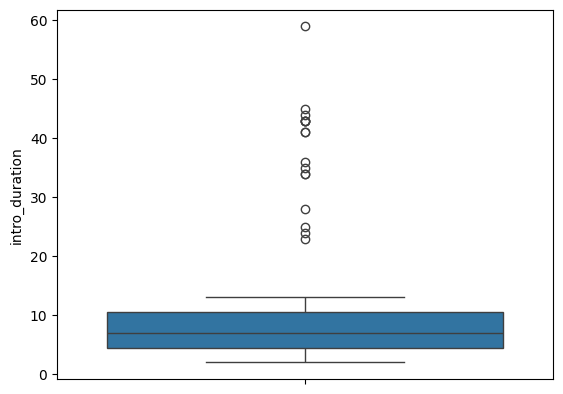

In [54]:
sns.boxplot(train_df['intro_duration'])

<Axes: ylabel='intro_duration'>

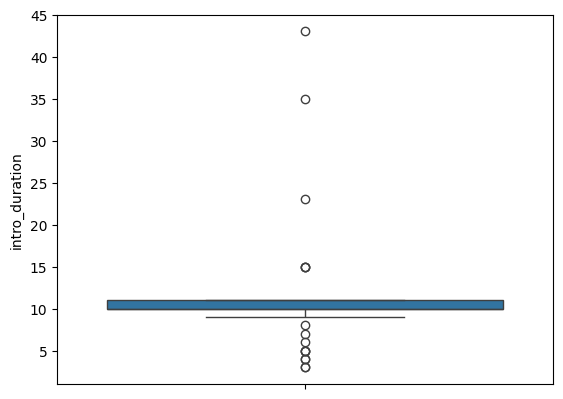

In [55]:
sns.boxplot(test_df['intro_duration'])

<Axes: ylabel='start_sec'>

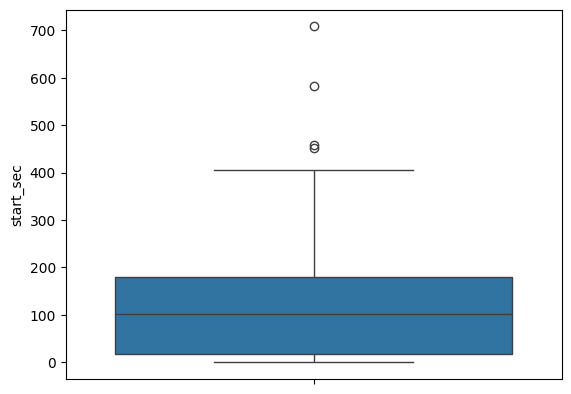

In [56]:
sns.boxplot(train_df['start_sec'])

<Axes: ylabel='start_sec'>

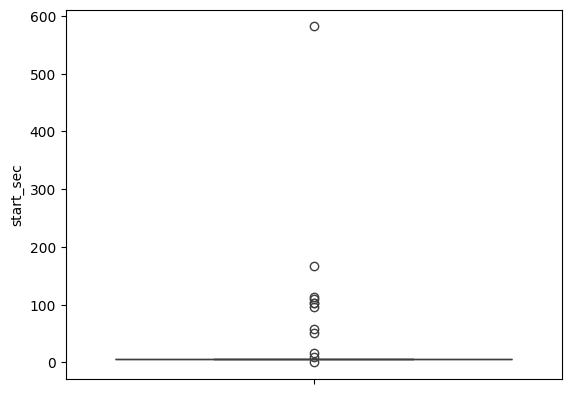

In [57]:
sns.boxplot(test_df['start_sec'])

# Подготовка входный последовательностей

In [58]:
def extract_labeled_frames(video_path, intro_start, intro_end, fps=1):
    cap = cv2.VideoCapture(video_path)
    video_fps = round(cap.get(cv2.CAP_PROP_FPS))
    step = int(video_fps // fps)

    frames = []
    labels = []
    times = []

    for i in range(intro_start*video_fps, (intro_start + 2*(intro_end - intro_start))*video_fps, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        time_sec = i / video_fps
        label = 1 if intro_start <= time_sec < intro_end else 0
        frames.append(frame)
        labels.append(label)
        times.append(time_sec)

    cap.release()
    return frames, labels

In [59]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_clip_features(frames):
    features = []
    for frame in frames:
        # Convert frame to RGB PIL image
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        # Preprocess and move to device
        inputs = processor(images=img, return_tensors="pt").to(device)
        
        # Extract features
        with torch.no_grad():
            outputs = model.get_image_features(**inputs)  # shape: [1, 512]
        
        features.append(outputs.cpu().squeeze())  # shape: [512]
    
    return features  # List of torch tensors [clip_dim]


## Train

In [60]:
all_features = []
all_labels = []
all_frames = []

for video_name in tqdm(list(train_df['video_id'])):
    video_path = f"data_train_short/{video_name}/{video_name}.mp4"
    start = train_df.loc[train_df['video_id'] == video_name]['start_sec'].values[0]
    end = train_df.loc[train_df['video_id'] == video_name]['end_sec'].values[0]
    duration = train_df.loc[train_df['video_id'] == video_name]['intro_duration'].values[0]
    
    frames, labels = extract_labeled_frames(video_path, start, end)
    all_frames.extend(frames)
    clip_features = extract_clip_features(frames)
    all_features.extend(clip_features)
    all_labels.extend(labels)

100%|██████████| 79/79 [01:01<00:00,  1.28it/s]


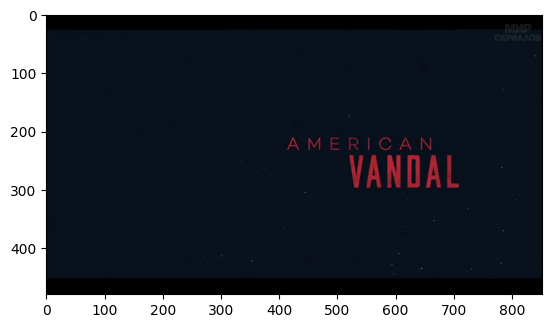

1


In [61]:
plt.imshow(Image.fromarray(cv2.cvtColor(all_frames[506], cv2.COLOR_BGR2RGB)))
plt.show()
print(all_labels[506])

In [63]:
len(all_frames)

2068

In [190]:
sum(all_labels) / len(all_labels)

0.5

In [ ]:
def split_into_chunks(features, labels, stride=5, chunk_size=60):
    X_chunks = []
    y_chunks = []
    for i in range(0, len(features) - chunk_size + 1, stride):
        X = torch.stack(features[i:i+chunk_size])  # shape: [60, clip_dim]
        y = torch.tensor(labels[i:i+chunk_size])   # shape: [60]
        X_chunks.append(X)
        y_chunks.append(y)
    return X_chunks, y_chunks

In [185]:
X_chunks, y_chunks = split_into_chunks(all_features, all_labels)

In [204]:
len(X_chunks)

402

In [189]:
len(X_chunks)

402

In [206]:
import os
os.makedirs("train_clip_sequences", exist_ok=True)

for i, (X, y) in enumerate(zip(X_chunks, y_chunks)):
    torch.save({'features': X, 'labels': y}, f"train_clip_sequences/seq_{i:04}.pt")

## Test

In [208]:
all_features = []
all_labels = []
all_frames = []

for video_name in tqdm(list(test_df['video_id'])):
    video_path = f"data_test_short/{video_name}/{video_name}.mp4"
    start = test_df.loc[test_df['video_id'] == video_name]['start_sec'].values[0]
    end = test_df.loc[test_df['video_id'] == video_name]['end_sec'].values[0]
    duration = test_df.loc[test_df['video_id'] == video_name]['intro_duration'].values[0]
    
    frames, labels = extract_labeled_frames(video_path, start, end)
    all_frames.extend(frames)
    clip_features = extract_clip_features(frames)
    all_features.extend(clip_features)
    all_labels.extend(labels)

100%|██████████| 45/45 [00:37<00:00,  1.19it/s]


In [209]:
len(all_frames)

992

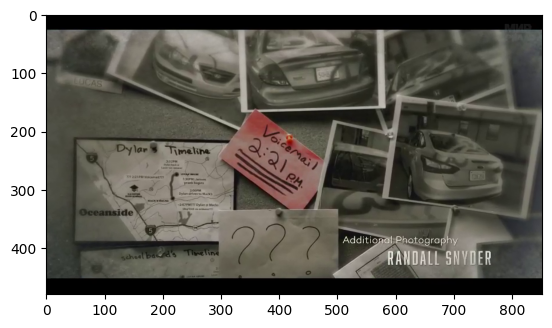

1


In [226]:
plt.imshow(Image.fromarray(cv2.cvtColor(all_frames[120], cv2.COLOR_BGR2RGB)))
plt.show()
print(all_labels[120])

In [227]:
X_chunks, y_chunks = split_into_chunks(all_features, all_labels)

In [228]:
os.makedirs("test_clip_sequences", exist_ok=True)

for i, (X, y) in enumerate(zip(X_chunks, y_chunks)):
    torch.save({'features': X, 'labels': y}, f"test_clip_sequences/seq_{i:04}.pt")

# Обучение модели

## Загрузка датасета и создание даталодера

In [2]:
class IntroSequenceDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted([
            os.path.join(data_dir, f)
            for f in os.listdir(data_dir)
            if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        item = torch.load(self.files[idx])
        features = item['features']   # [60, 512]
        labels = item['labels']       # [60]
        return features, labels


In [3]:
batch_size = 8

train_dataset = IntroSequenceDataset("train_clip_sequences")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = IntroSequenceDataset("test_clip_sequences")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [238]:
next(iter(train_loader))[1].shape

torch.Size([8, 60])

In [237]:
len(train_loader)

51

## Модель

In [4]:
class IntroDetector(nn.Module):
    def __init__(self, clip_dim=512, seq_len=60, num_layers=16, num_heads=16, ff_dim=2048):
        super().__init__()
        self.seq_len = seq_len
        self.clip_dim = clip_dim

        # Learnable positional embeddings: [1, 60, 512]
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, clip_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=clip_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Frame-wise classifier: outputs 1 logit per frame
        self.classifier = nn.Linear(clip_dim, 1)

    def forward(self, x):  # x: [batch_size, 60, 512]
        x = x + self.pos_embedding  # Add position info
        x = self.transformer(x)     # Apply attention
        logits = self.classifier(x) # Shape: [batch_size, 60, 1]
        return logits.squeeze(-1)   # [batch_size, 60]


### intro_detector_0 (Test accuracy: 0.7800)

In [243]:
model = IntroDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_predictions = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device).float()
        logits = model(features)  # [B, 60]
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute per-frame accuracy
        preds = torch.sigmoid(logits) > 0.5  # Binary prediction
        correct = (preds == labels.bool()).sum().item()
        total_correct += correct
        total_predictions += labels.numel()  # total number of elements in label tensor

    accuracy = total_correct / total_predictions
    avg_loss = running_loss / len(train_loader)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 0.7029, Accuracy: 0.5067
Epoch 2, Loss: 0.7006, Accuracy: 0.4959
Epoch 3, Loss: 0.6955, Accuracy: 0.5178
Epoch 4, Loss: 0.6803, Accuracy: 0.5704
Epoch 5, Loss: 0.6605, Accuracy: 0.6069
Epoch 6, Loss: 0.6377, Accuracy: 0.6364
Epoch 7, Loss: 0.4708, Accuracy: 0.8054
Epoch 8, Loss: 0.4248, Accuracy: 0.8374
Epoch 9, Loss: 0.3566, Accuracy: 0.8617
Epoch 10, Loss: 0.3103, Accuracy: 0.8752
Epoch 11, Loss: 0.2871, Accuracy: 0.8842
Epoch 12, Loss: 0.2507, Accuracy: 0.8948
Epoch 13, Loss: 0.2181, Accuracy: 0.9090
Epoch 14, Loss: 0.1934, Accuracy: 0.9162
Epoch 15, Loss: 0.1762, Accuracy: 0.9235
Epoch 16, Loss: 0.1519, Accuracy: 0.9340
Epoch 17, Loss: 0.1332, Accuracy: 0.9423
Epoch 18, Loss: 0.1165, Accuracy: 0.9499
Epoch 19, Loss: 0.1000, Accuracy: 0.9588
Epoch 20, Loss: 0.0890, Accuracy: 0.9625


In [249]:
def accuracy(preds, labels):
    """
    preds: Tensor of shape (batch_size, seq_len)
           or (batch_size, seq_len, 1) — predicted probabilities or logits
    labels: Tensor of shape (batch_size, seq_len) — ground truth labels (0 or 1)

    Returns: scalar accuracy value
    """
    preds = (preds > 0.5).long()  # for binary classification with sigmoid output
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

In [ ]:
model.eval()
total_acc = 0
total_samples = 0

with torch.no_grad():
    for batch in train_loader:  # train or test dataloader
        inputs, labels = batch  # inputs: (B, 60, D), labels: (B, 60)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # should return shape (B, 60)
        acc = accuracy(outputs, labels)

        total_acc += acc * labels.size(0)  # accumulate weighted by batch size
        total_samples += labels.size(0)

final_acc = total_acc / total_samples
print(f"Accuracy: {final_acc:.4f}")


Accuracy: 0.9681


In [255]:
model.eval()
total_acc = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:  # train or test dataloader
        inputs, labels = batch  # inputs: (B, 60, D), labels: (B, 60)
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # should return shape (B, 60)
        acc = accuracy(outputs, labels)

        total_acc += acc * labels.size(0)  # accumulate weighted by batch size
        total_samples += labels.size(0)

final_acc = total_acc / total_samples
print(f"Test accuracy: {final_acc:.4f}")

Test accuracy: 0.7800


In [257]:
torch.save(model.state_dict(), "model_weights/intro_detector_0.pth")

### intro_detector_1 (Test Accuracy: 0.8051)

In [8]:
import torch
import torch.nn as nn

def accuracy(preds, labels):
    preds = (preds > 0.5).long()
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

def train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: (B, 60)

            loss = criterion(outputs, labels.float())  # binary classification
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += (outputs > 0.5).long().eq(labels).sum().item()
            train_total += labels.numel()

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / train_total

        # Evaluate on test set
        model.eval()
        test_correct = 0
        test_total = 0
        test_loss = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())

                test_loss += loss.item() * labels.size(0)
                test_correct += (outputs > 0.5).long().eq(labels).sum().item()
                test_total += labels.numel()

        test_acc = test_correct / test_total
        avg_test_loss = test_loss / test_total

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        print(f"Test  Loss: {avg_test_loss:.4f}, Accuracy: {test_acc:.4f}")
        print("-" * 40)


In [19]:
model = IntroDetector().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs=40)

Epoch 1/40
Train Loss: 0.0122, Accuracy: 0.4939
Test  Loss: 0.0117, Accuracy: 0.5010
----------------------------------------
Epoch 2/40
Train Loss: 0.0118, Accuracy: 0.4963
Test  Loss: 0.0116, Accuracy: 0.5010
----------------------------------------
Epoch 3/40
Train Loss: 0.0117, Accuracy: 0.4959
Test  Loss: 0.0116, Accuracy: 0.5010
----------------------------------------
Epoch 4/40
Train Loss: 0.0116, Accuracy: 0.4971
Test  Loss: 0.0117, Accuracy: 0.5010
----------------------------------------
Epoch 5/40
Train Loss: 0.0117, Accuracy: 0.4959
Test  Loss: 0.0116, Accuracy: 0.5010
----------------------------------------
Epoch 6/40
Train Loss: 0.0117, Accuracy: 0.4971
Test  Loss: 0.0116, Accuracy: 0.5010
----------------------------------------
Epoch 7/40
Train Loss: 0.0116, Accuracy: 0.4961
Test  Loss: 0.0116, Accuracy: 0.5010
----------------------------------------
Epoch 8/40
Train Loss: 0.0116, Accuracy: 0.4978
Test  Loss: 0.0117, Accuracy: 0.5010
---------------------------------

In [24]:
torch.save(model.state_dict(), "model_weights/intro_detector_1.pth")

# Метрики Precision, Recall, F1-score

In [20]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(preds, targets, threshold=0.5):
    """
    Computes precision, recall, and F1 score.

    Args:
        preds (Tensor): model outputs (logits), shape [batch_size, 60]
        targets (Tensor): ground truth labels, shape [batch_size, 60]
        threshold (float): classification threshold

    Returns:
        dict: precision, recall, f1 score
    """
    # Apply sigmoid and flatten
    preds = torch.sigmoid(preds).view(-1).cpu().detach().numpy()
    targets = targets.view(-1).cpu().detach().numpy()

    # Binarize predictions
    preds_binary = (preds >= threshold).astype(int)

    # Compute metrics
    precision = precision_score(targets, preds_binary, zero_division=0)
    recall = recall_score(targets, preds_binary, zero_division=0)
    f1 = f1_score(targets, preds_binary, zero_division=0)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

### intro_detector_0

In [26]:
model = IntroDetector().to(device)

# Load the state dictionary
state_dict = torch.load('model_weights\intro_detector_0.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
all_preds = []
all_targets = []

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(inputs)  # [B, 60]

    all_preds.append(logits)
    all_targets.append(labels)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Compute and print metrics
metrics = compute_metrics(all_preds, all_targets)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1_score"])

Precision: 0.9750041799030262
Recall: 0.9606292727122971
F1 Score: 0.9677633489607103


In [28]:
all_preds = []
all_targets = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(inputs)  # [B, 60]

    all_preds.append(logits)
    all_targets.append(labels)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Compute and print metrics
metrics = compute_metrics(all_preds, all_targets)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1_score"])

Precision: 0.7801941049604602
Recall: 0.7753170208965887
F1 Score: 0.777747917226552


### intro_detector_1

In [36]:
model = IntroDetector().to(device)

# Load the state dictionary
state_dict = torch.load('model_weights\intro_detector_1.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [37]:
all_preds = []
all_targets = []

for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(inputs)  # [B, 60]

    all_preds.append(logits)
    all_targets.append(labels)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Compute and print metrics
metrics = compute_metrics(all_preds, all_targets)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1_score"])

Precision: 0.9949872627167392
Recall: 0.9972819372374598
F1 Score: 0.9961332784862197


In [38]:
all_preds = []
all_targets = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(inputs)  # [B, 60]

    all_preds.append(logits)
    all_targets.append(labels)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Compute and print metrics
metrics = compute_metrics(all_preds, all_targets)
print("Precision:", metrics["precision"])
print("Recall:", metrics["recall"])
print("F1 Score:", metrics["f1_score"])

Precision: 0.8100325968851865
Recall: 0.7988926594034649
F1 Score: 0.8044240625843


# Mess

In [ ]:

def extract_labeled_frames(video_path, intro_start, intro_end, fps=1):
    cap = cv2.VideoCapture(video_path)
    video_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = int(video_fps // fps)

    frames = []
    labels = []
    times = []

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        time_sec = i / video_fps
        label = 1 if intro_start <= time_sec < intro_end else 0
        frames.append(frame)
        labels.append(label)
        times.append(time_sec)

    cap.release()
    return frames, labels


In [99]:
video_name = list(train_df['video_id'])[1]

In [100]:
train_df.loc[train_df['video_id'] == video_name]

,video_id,url,name,start,end,start_sec,end_sec,intro_duration
1,-220020068_456249693,https://vkvideo.ru/video-220020068_456249693,"Бывaeт и xyжe. 1 сезон, 14 серия",0:00:06,0:00:10,6,10,4


In [101]:
train_df.loc[train_df['video_id'] == video_name]['start_sec'].values[0]

6

In [102]:
start = train_df.loc[train_df['video_id'] == video_name]['start_sec'].values[0]
end = train_df.loc[train_df['video_id'] == video_name]['end_sec'].values[0]
duration = train_df.loc[train_df['video_id'] == video_name]['intro_duration'].values[0]

In [130]:
img = Image.fromarray(cv2.cvtColor(frames[4], cv2.COLOR_BGR2RGB))

In [106]:
len(frames)

8

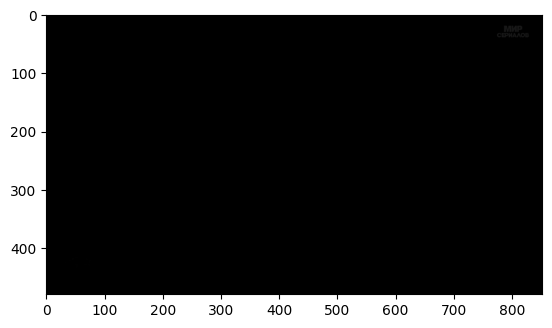

In [117]:
plt.imshow(frames[1])

In [40]:
f"data_train_short/{list(train_df['video_id'])[0]}/{list(train_df['video_id'])[0]}.mp4"

'data_train_short/-220020068_456255414/-220020068_456255414.mp4'

In [35]:
'data_train_short/' + list(train_df['video_id'])[0] + list(train_df['video_id'])[0] + '.mp4'

'data_train_short/-220020068_456255414-220020068_456255414.mp4'

In [34]:
list(train_df['video_id'])

['-220020068_456255414',
 '-220020068_456249693',
 '-220020068_456255339',
 '-220020068_456241755',
 '-220020068_456241671',
 '-220020068_456255340',
 '-220020068_456241756',
 '-220020068_456256016',
 '-220020068_456249732',
 '-220020068_456255332',
 '-220020068_456241672',
 '-220020068_456255341',
 '-220020068_456256475',
 '-220020068_456256013',
 '-220020068_456248657',
 '-220020068_456241673',
 '-220020068_456255402',
 '-220020068_456257139',
 '-220020068_456254621',
 '-220020068_456241758',
 '-220020068_456249739',
 '-220020068_456255403',
 '-220020068_456256012',
 '-220020068_456249716',
 '-220020068_456255389',
 '-220020068_456257141',
 '-220020068_456241851',
 '-220020068_456256571',
 '-220020068_456256019',
 '-220020068_456249720',
 '-220020068_456255344',
 '-220020068_456255405',
 '-220020068_456255391',
 '-220020068_456241844',
 '-220020068_456254282',
 '-220020068_456239859',
 '-220020068_456255346',
 '-220020068_456255392',
 '-220020068_456241845',
 '-220020068_456255766',


In [121]:
data = extract_clip_features(frames)

In [122]:
len(data)

8

In [128]:
data[0].size()

torch.Size([512])

In [135]:
os.listdir('data_train_short')

['-220020068_456239859',
 '-220020068_456241671',
 '-220020068_456241672',
 '-220020068_456241673',
 '-220020068_456241682',
 '-220020068_456241755',
 '-220020068_456241756',
 '-220020068_456241758',
 '-220020068_456241844',
 '-220020068_456241845',
 '-220020068_456241846',
 '-220020068_456241847',
 '-220020068_456241849',
 '-220020068_456241850',
 '-220020068_456241851',
 '-220020068_456248657',
 '-220020068_456249667',
 '-220020068_456249692',
 '-220020068_456249693',
 '-220020068_456249716',
 '-220020068_456249719',
 '-220020068_456249720',
 '-220020068_456249732',
 '-220020068_456249733',
 '-220020068_456249739',
 '-220020068_456252055',
 '-220020068_456253855',
 '-220020068_456253876',
 '-220020068_456254282',
 '-220020068_456254537',
 '-220020068_456254614',
 '-220020068_456254621',
 '-220020068_456255332',
 '-220020068_456255338',
 '-220020068_456255339',
 '-220020068_456255340',
 '-220020068_456255341',
 '-220020068_456255344',
 '-220020068_456255346',
 '-220020068_456255349',


In [138]:
len(all_features)

2068

In [141]:
len(all_labels)

2068